In [1]:
import os
import itertools
import random
from typing import Sequence

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Ensure 3D plotting is available
import torch
from pathlib import Path
from pytorch_lightning import seed_everything
from torch.nn import functional as F
import numpy as np




try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum
from enum import auto

# from nn_core.common import PROJECT_ROOT
import pickle

print(os.path.abspath(os.curdir))
os.chdir("..")
print(os.path.abspath(os.curdir))
from src.zeroshotrl.rl_agents.ppo.ppo_end_to_end_relu_stack_align import FeatureExtractor
# from src.zeroshotrl.rl_agents.ppo.ppo_end_to_end_relu_stack_align_hidden import Policy
from src.zeroshotrl.utils.relative import *
from src.zeroshotrl.utils.notebooks import *

import latentis

print(latentis.__version__)

# Relative stuff
from latentis.space import LatentSpace
from latentis.project import RelativeProjector
from latentis.project import relative
from latentis.transform import Centering, StandardScaling

# from latentis.transform.base import StandardScaling, Centering
# from latentis.transform.dim_matcher import ZeroPadding
# from latentis.transform.translate.aligner import MatrixAligner, Translator
# from latentis.transform.translate.functional import (
#     svd_align_state,
# )


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum
from enum import auto

from zeroshotrl.utils.relative import *
from zeroshotrl.utils.notebooks import *

/Users/antonioricciardi/projects/rl_relrepr_gymnasium/notebooks
/Users/antonioricciardi/projects/rl_relrepr_gymnasium
0.0.7


In [2]:
from latentis.space import LatentSpace
from latentis.utils import seed_everything

# from latentis import transforms
from latentis.estimate.dim_matcher import ZeroPadding
from latentis.estimate.orthogonal import SVDEstimator
from latentis.estimate.linear import LSTSQEstimator
from latentis.estimate.affine import SGDAffineTranslator
from latentis.translate.translator import LatentTranslator


from src.zeroshotrl.utils.anchoring_methods import get_anchors

In [3]:
from tueplots import bundles

# plt.rcParams.update(bundles.icml2022())
bundles.icml2022()

CMAP = "jet"

# DATA_DIR: Path = PROJECT_ROOT
# print files in the current working directory
print(os.listdir(os.curdir))

['test_grads.ipynb', 'models.dvc', 'miniworld_train.py', '.DS_Store', 'miniworld_test.py', 'requirements.txt', 'uv.lock', 'data_collection', 'minigrid_original', 'ppo_atari_lstm.py', '.pre-commit-config.yaml', '.ruff_cache', 'experiments', 'paper_data', 'collect_data.sh', 'pyproject.toml', '.dvc', 'eval_1_synthetic.csv', 'old', 'vizdoom_scenarios', 'models', 'finetuning', '__pycache__', 'test.py', 'environment_mac.yml', 'README.md', '_vizdoom.ini', 'sac.py', '.gitignore', 'data.dvc', 'ppo.gin', '.venv', 'vizdoom_test.py', 'scripts', 'scenarios', 'relative_rl_requirements_mac_old.txt', 'ppo_miniworld_logs', '.git', 'alignment_indices', 'paper_stuff.tex', 'a2c.py', 'data', 'test.ipynb', 'runs', 'a2c copy.py', 'notebooks', 'requirements_mac.txt', 'wandb', '.dvcignore', 'paper_relrepr', 'src']


In [4]:

anchors_env_id1 = "LunarLanderRGB" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" # "LunarLanderRGB"
anchors_env_id2 = "LunarLanderRGB" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" # "LunarLanderRGB"
obs_env_id1 = "LunarLanderRGB" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" #"LunarLanderRGB"
obs_env_id2 = "LunarLanderRGB-3" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" # "LunarLanderRGB"

anchors_color1 = "red" # "standard"
anchors_color2 = "white" # "standard"

color1 = "red" # "standard"
color2 = "white" # "standard"

layers_list = ['enc', 'pol']
layer_to_use = layers_list[0]

enc1_seed = 1
enc2_seed = 1

anchors_path1 = f"data/anchors/{anchors_env_id1}/rgb_ppo_transitions_{anchors_color1}_obs.pkl"
anchors_path2 = f"data/anchors/{anchors_env_id2}/rgb_ppo_transitions_{anchors_color2}_obs.pkl"
obs_path1 = f"data/anchors/{obs_env_id1}/rgb_ppo_transitions_{color1}_obs.pkl"
obs_path2 = f"data/anchors/{obs_env_id2}/rgb_ppo_transitions_{color2}_obs.pkl"


algo1 = "ppo"
algo2 = "ppo"
env_id1 = obs_env_id1# "CarRacing-v2"
env_id2 = obs_env_id2# "CarRacing-v2-bus"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc1_path = f"models/{env_id1}/rgb/{color1}/{algo1}/absolute/relu/seed_{enc1_seed}/encoder.pt"
enc2_path = f"models/{env_id2}/rgb/{color2}/{algo2}/absolute/relu/seed_{enc2_seed}/encoder.pt"
encoder1_dict = torch.load(
    enc1_path,
    map_location=device,
)
encoder2_dict = torch.load(
    enc2_path,
    map_location=device,
)

In [5]:
encoder1 = FeatureExtractor()
encoder2 = FeatureExtractor()
encoder1.load_state_dict(encoder1_dict)
encoder2.load_state_dict(encoder2_dict)

<All keys matched successfully>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder1.to(device)
encoder2.to(device)


obs_set_1 = pickle.load(Path(obs_path1).open("rb"))  # [30:2000]
obs_set_2 = pickle.load(Path(anchors_path2).open("rb"))  # [30:2000]
print("\n#####\nObs loaded\n#####\n")

anchors_set_1 = pickle.load(Path(anchors_path1).open("rb"))
anchors_set_2 = pickle.load(Path(anchors_path2).open("rb"))
anchors_set_1 = torch.tensor(np.array(anchors_set_1), dtype=torch.float32)
anchors_set_2 = torch.tensor(np.array(anchors_set_2), dtype=torch.float32)
# subset_indices = np.random.randint(0, len(obs_set_1), 5000)
obs_set_1 = obs_set_1
obs_set_2 = obs_set_2

print("Converting obs to torch tensor")
# convert the (4000, 3, 84, 84) numpy array to a torch tensor
obs_set_1 = torch.tensor(np.array(obs_set_1), dtype=torch.float32)
obs_set_2 = torch.tensor(np.array(obs_set_2), dtype=torch.float32)
print("Done converting obs to torch tensor\n#####\n")

# obs_set_1 = torch.cat([obs_set_1, obs_set_2], dim=0)  # [anch_indices
# obs_set_2 = obs_set_1

# obs_set_1 = torch.cat(obs_set_1, dim=0).cpu()  # [anch_indices]
# obs_set_2 = torch.cat(obs_set_2, dim=0).cpu()  # [anch_indices]
space1 = encoder1.forward_single(obs_set_1[:900].to(device))#.detach().cpu()
space2 = encoder2.forward_single(obs_set_2[:900].to(device))#.detach().cpu()


#####
Obs loaded
#####

Converting obs to torch tensor
Done converting obs to torch tensor
#####



In [7]:
# randomly sample 1000 anchors from each set
random_indexing = torch.randperm(anchors_set_1.size(0))[:1000]

# anchors_space1 = encoder1.forward_single(anchors_set_1[random_indexing].to(device)).detach().cpu()
# anchors_space2 = encoder2.forward_single(anchors_set_2[random_indexing].to(device)).detach().cpu()

anchors_space1 = encoder1.forward_single(anchors_set_1.to(device)).detach().cpu()
anchors_space2 = encoder2.forward_single(anchors_set_2.to(device)).detach().cpu()

anchors_space1 = anchors_space1[random_indexing]
anchors_space2 = anchors_space2[random_indexing]

# # center anchors
# anchors_space1_mean = anchors_space1.mean(dim=0)
# anchors_space2_mean = anchors_space2.mean(dim=0)

# center_anchor_translations = torch.cdist(
#     anchors_space1_mean.unsqueeze(0), anchors_space2_mean.unsqueeze(0), p=2
# )

# anchors_space1 = anchors_space1 - anchors_space1.mean(
#     dim=0
# )  # / anchors_space1.std(dim=0)
# anchors_space2 = anchors_space2 - anchors_space2.mean(
#     dim=0
# )  # / anchors_space2.std(dim=0)
# center_anchor_translations = torch.cdist(
#     anchors_space1.mean(dim=0, keepdim=True),
#     anchors_space2.mean(dim=0, keepdim=True).unsqueeze(0),
#     p=2,
# )

# norm_anchors_space1: torch.Tensor = F.normalize(anchors_space1, p=2, dim=-1)
# norm_anchors_space2: torch.Tensor = F.normalize(anchors_space2, p=2, dim=-1)

# assert norm_anchors_space1.shape == norm_anchors_space2.shape


# norm_space1 = space1 - anchors_space1_mean  #  / self.anchors_std
# norm_space1: torch.Tensor = F.normalize(norm_space1, p=2, dim=-1)

# norm_space2 = space2 - anchors_space2_mean  #  / self.anchors_std
# norm_space2: torch.Tensor = F.normalize(norm_space2, p=2, dim=-1)

In [8]:
subset_indices = np.arange(len(anchors_space1))  # [:4000]

In [9]:
anchors_set_1.shape, anchors_set_2.shape, obs_set_1.shape, obs_set_2.shape, space1.shape, space2.shape, anchors_space1.shape, anchors_space2.shape

(torch.Size([4000, 3, 84, 84]),
 torch.Size([4000, 3, 84, 84]),
 torch.Size([4000, 3, 84, 84]),
 torch.Size([4000, 3, 84, 84]),
 torch.Size([900, 3136]),
 torch.Size([900, 3136]),
 torch.Size([1000, 3136]),
 torch.Size([1000, 3136]))

In [10]:
obs_set_1.max(), obs_set_2.max(), anchors_set_1.max(), anchors_set_2.max()

(tensor(1.), tensor(1.), tensor(1.), tensor(1.))

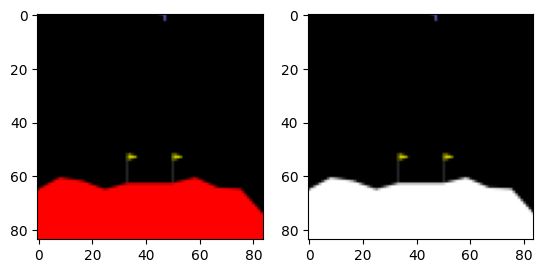

In [11]:
# plot obs_set_1 and obs_set_2 images in a subplot
i = 640
fig, ax = plt.subplots(1, 2)
ax[0].imshow(anchors_set_1[i].permute(1, 2, 0))
ax[1].imshow(anchors_set_2[i].permute(1, 2, 0))
plt.show()

In [12]:

# space1 = encoder1.forward_single(obs_set_1.to(device)).detach().cpu()#[:900]
# space2 = encoder2.forward_single(obs_set_2.to(device)).detach().cpu()#[:900]

# compute mean distance between anchors
diff = space1 - space2
print("mean distance between anchors: ", diff.mean())
print(len(space1), len(space2))

mse = torch.nn.MSELoss()
print(mse(space1, space2))

mean distance between anchors:  tensor(0.0404, grad_fn=<MeanBackward0>)
900 900
tensor(0.1150, grad_fn=<MseLossBackward0>)


In [13]:
import latentis.transform

anchoring_method = "random"
# encoder_dir = "models/CarRacing-v2/rgb/green/ppo/absolute/relu/seed_2"
encoder_dir = str(enc1_path).replace("encoder.pt", "")

align_path = os.path.join(
    "alignment_indices", str(encoder_dir).replace("models/", "")
)
if not os.path.exists(align_path):
    os.makedirs(align_path)
translation_path = os.path.join(align_path, f"{anchoring_method}_closest.pt")

num_anchors = 900  # len(space1_anchors) # 3136
space1_anchors, space2_anchors = get_anchors(
    anchors_space1,
    anchors_space2,
    num_anchors,
    subset_indices,
    anchoring_method,
    translation_path,
    use_saved=False,
    device=device
)


translation = LatentTranslator(
    random_seed=42,
    # estimator=LSTSQEstimator(),
    estimator=SVDEstimator(
        dim_matcher=ZeroPadding()
    ),  # SGDAffineTranslator(),#SVDEstimator(dim_matcher=ZeroPadding()),
    source_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()], #None
    target_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()],
)

translation = LatentTranslator(
    random_seed=42,
    estimator = SGDAffineTranslator(),#SVDEstimator(dim_matcher=ZeroPadding()),
    source_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()], #None
    target_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()],
)
# translation = LatentTranslation(
#     seed=42,
#     translator=SVDTranslator(),
#     source_transforms=None, #[Transforms.StandardScaling()],
#     target_transforms=None, #[Transforms.StandardScaling()],
# )
space1_anchors = space1_anchors.to(device)  # [:3136]
space2_anchors = space2_anchors.to(device)  # [:3136]


# shuffle anchors and sort by their value along the dim d (they have shape (n,d))
space1_anchors = space1_anchors[torch.randperm(space1_anchors.size(0))]
space1_anchors, sorted_indices2 = space1_anchors.sort(dim=0, descending=True)

space2_anchors = space2_anchors[torch.randperm(space2_anchors.size(0))]
space2_anchors, sorted_indices2 = space2_anchors.sort(dim=0, descending=True)

gettin random anchors
random done


In [14]:
# print mse and cosine similarity between the two spaces
mse = torch.nn.MSELoss()
cos = torch.nn.CosineSimilarity()
print(
    f"mean squared error between the two spaces: {mse(space1_anchors, space2_anchors)}"
)
print(
    f"cosine similarity between the two spaces: {cos(space1_anchors, space2_anchors).mean()}"
)

mean squared error between the two spaces: 0.05581879988312721
cosine similarity between the two spaces: 0.5201734900474548


In [15]:
import torch

def marginal_sort_lstsq(x, y):
    """
    x: (n, d) tensor - samples from source distribution
    y: (n, d) tensor - samples from target distribution
    Returns: (d, 2) tensor - affine parameters per dimension (slope, intercept)
    """
    n, d = x.shape
    x_sorted = torch.sort(x, dim=0).values  # sort each column
    y_sorted = torch.sort(y, dim=0).values

    coeffs = []
    ones = torch.ones((n, 1), device=x.device)

    for j in range(d):
        A = torch.cat([x_sorted[:, j:j+1], ones], dim=1)  # (n, 2): [x, 1]
        sol = torch.linalg.lstsq(y_sorted[:, j:j+1], A).solution  # legacy version
        # for PyTorch >= 1.9, use torch.linalg.lstsq:
        # sol = torch.linalg.lstsq(A, y_sorted[:, j:j+1]).solution
        coeffs.append(sol[:2].squeeze())

    return torch.stack(coeffs)  # shape: (d, 2)

def apply_affine_map(x_new, coeffs):
    """
    Apply per-dimension affine transform to x_new using learned coeffs
    x_new: (m, d) tensor
    coeffs: (d, 2) tensor, where coeffs[:, 0] = slope, coeffs[:, 1] = intercept
    Returns: (m, d) transformed tensor
    """
    slope = coeffs[:, 0]
    intercept = coeffs[:, 1]
    return x_new * slope + intercept

In [16]:
import torch

def linear_ot_gaussian(x, y, eps=1e-6):
    """
    Estimate optimal linear transport map (A, b) such that y ≈ x @ A.T + b
    Assumes x, y ~ continuous distributions, not paired
    """
    # Center the data
    x_mean = x.mean(0)
    y_mean = y.mean(0)
    x_c = x - x_mean
    y_c = y - y_mean

    # Covariance
    cov_x = x_c.T @ x_c / (x.shape[0] - 1) + eps * torch.eye(x.shape[1], device=x.device)
    cov_y = y_c.T @ y_c / (y.shape[0] - 1) + eps * torch.eye(y.shape[1], device=y.device)

    # Square roots via symmetric eigendecomposition
    # def sqrtm(mat):
    #     eigvals, eigvecs = torch.linalg.eigh(mat)
    #     return eigvecs @ torch.diag(torch.sqrt(torch.clamp(eigvals, min=0))) @ eigvecs.T
    def sqrtm(mat):
        # Enforce symmetry and use double precision for stability
        mat = ((mat + mat.T) / 2).double()
        eigvals, eigvecs = torch.linalg.eigh(mat)
        sqrt_eigvals = torch.sqrt(torch.clamp(eigvals, min=0))
        sqrt_mat = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.T
        return sqrt_mat.float()  # Convert back if needed

    cov_x_sqrt = sqrtm(cov_x)
    inv_cov_x_sqrt = torch.linalg.inv(cov_x_sqrt)
    middle = sqrtm(cov_x_sqrt @ cov_y @ cov_x_sqrt)

    A = inv_cov_x_sqrt @ middle @ inv_cov_x_sqrt
    b = y_mean - x_mean @ A.T

    return A.T, b  # Return in form y ≈ x @ A.T + b

# def apply_linear_map(x_new, A, b):
#     return x_new @ A + b


def apply_linear_map_loop(x_new, A, b):
    """
    Applies a linear map to x_new using a for loop.
    
    Args:
        x_new (torch.Tensor): Input tensor of shape (m, d)
        A (torch.Tensor): Transformation matrix of shape (d, d)
        b (torch.Tensor): Bias vector of shape (d,)
    
    Returns:
        torch.Tensor: Transformed tensor of shape (m, d)
    """
    m = x_new.shape[0]           # Number of samples
    d = A.shape[1]               # Dimension of the transformation output
    
    # Allocate an empty tensor with the same device and dtype as x_new
    result = torch.empty(m, d, device=x_new.device, dtype=x_new.dtype)
    
    # Loop over each sample and compute: result[i] = x_new[i] @ A + b
    for i in range(m):
        result[i] = x_new[i] @ A + b
    
    return result

In [17]:
def pca_procrustes(x, y, k=None):
    """
    Estimate linear map A and bias b that approximately aligns x to y,
    assuming the rows are unpaired but distributions aligned.

    Args:
        x: (n, d) source data
        y: (n, d) target data
        k: number of components (default: full rank)
    Returns:
        A: (d, d) estimated linear map
        b: (d,) estimated bias
    """
    x_mean = x.mean(0)
    y_mean = y.mean(0)
    x_c = x - x_mean
    y_c = y - y_mean

    # PCA on features (d x d)
    Ux, _, _ = torch.linalg.svd(x_c.T, full_matrices=False)  # Ux: d x d
    Uy, _, _ = torch.linalg.svd(y_c.T, full_matrices=False)  # Uy: d x d

    if k is not None:
        Ux = Ux[:, :k]
        Uy = Uy[:, :k]

    # Rotation from x space to y space
    A = Uy @ Ux.T
    b = y_mean - x_mean @ A.T
    return A.T, b

In [19]:
# # Learn mapping
# coeffs = marginal_sort_lstsq(space1_anchors, space2_anchors)

# # Transform a new sample from source
# x_new = torch.tensor([[0.0, 1.0, -1.0]])
# translated_space1 = apply_affine_map(space1, coeffs)

# coeffs = linear_ot_gaussian(space1_anchors, space2_anchors)
coeffs = pca_procrustes(space1_anchors, space2_anchors)
# Transform a new sample from source
translated_space1 = apply_linear_map_loop(space1, *coeffs)


In [20]:
space1_anchors.shape, space2_anchors.shape

(torch.Size([900, 3136]), torch.Size([900, 3136]))

In [21]:
# space1 = space1[:900]
# space2 = space2[:900]

# translated_space1 = translation(space1)
print("Computing avg pairwise distances between space1 and space2...")
print(torch.cdist(space1, space2, p=2).mean())

print("\n##############################################\n")
print("Computing avg pairwise distances between translated space1 and space2...")
pairwise_dist_translated = torch.cdist(translated_space1, space2, p=2).mean()
print(pairwise_dist_translated)

# print cosine similarities between space1 and space2, and translated space1 and space2
cos = torch.nn.CosineSimilarity(dim=1)
cos_sim = cos(space1, space2)
print("cosine similarity between space1 and space2: ", cos_sim.mean())

cos = torch.nn.CosineSimilarity(dim=1)
cos_sim = cos(translated_space1, space2)
print(
    "cosine similarity between translated space1 and space2: ",
    cos_sim.mean(),
)

Computing avg pairwise distances between space1 and space2...
tensor(19.5009, grad_fn=<MeanBackward0>)

##############################################

Computing avg pairwise distances between translated space1 and space2...
tensor(16.5980, grad_fn=<MeanBackward0>)
cosine similarity between space1 and space2:  tensor(0.3644, grad_fn=<MeanBackward0>)
cosine similarity between translated space1 and space2:  tensor(0.0554, grad_fn=<MeanBackward0>)


In [22]:
projector = RelativeProjector(
    projection_fn=relative.cosine_proj,
    abs_transforms=[Centering(), StandardScaling()],
)
projector.to(device)

rel_space1 = projector(x=space1[:800], anchors=space1_anchors).detach().cpu()  # .vectors
rel_space2 = projector(x=space2[:800], anchors=space2_anchors).detach().cpu()  # .vectors

In [23]:
space1 = space1.detach().cpu()
space2 = space2.detach().cpu()
translated_space1 = translated_space1.detach().cpu()

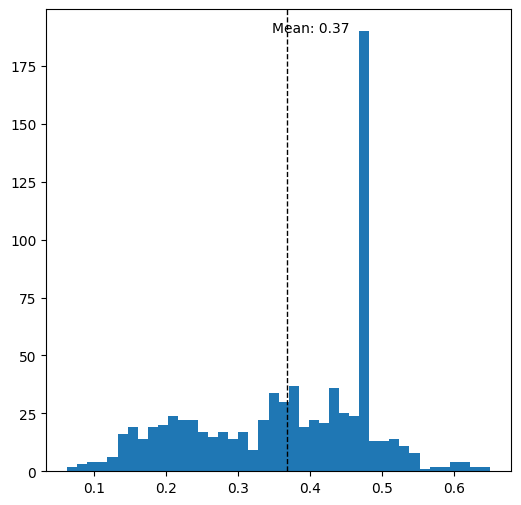

In [24]:
fig = plot_pairwise_dist(space1=space1[:800], space2=space2[:800], prefix="Absolute", dist_method="cosine", show_title=False)
# save fig
fig.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_pairwise_dist_abs.pdf", bbox_inches='tight')
fig

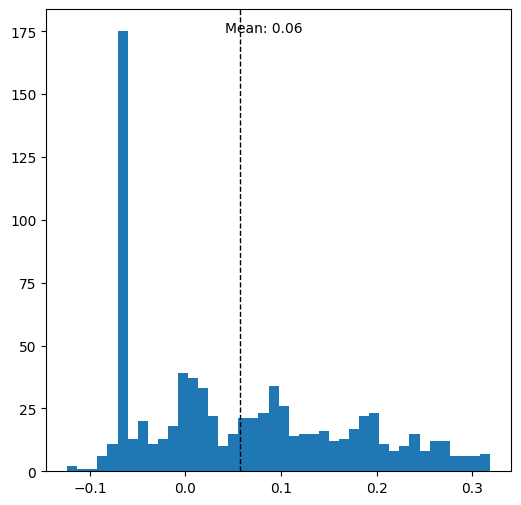

In [25]:
fig = plot_pairwise_dist(space1=translated_space1[:800], space2=space2[:800], prefix="SAPS", dist_method="cosine", show_title=False)
# save fig
fig.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_pairwise_dist_transl.pdf", bbox_inches='tight')
fig

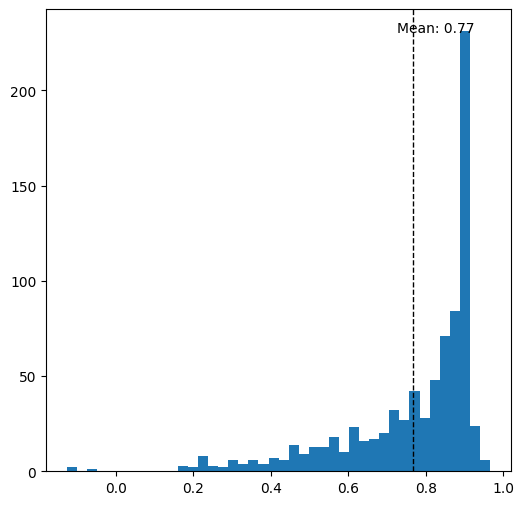

In [26]:
fig = plot_pairwise_dist(space1=rel_space1[:800], space2=rel_space2[:800], prefix="R3L", dist_method="cosine", show_title=False)
# save fig
fig.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_pairwise_dist_rel.pdf", bbox_inches='tight')
fig

In [ ]:
import plotly.subplots as sp
import plotly.graph_objects as go

episode_space1 = space1[:800] # [:85]
episode_space2 = space2[:800] # [:85]
episode_rel_space1 = translated_space1[:800] # [:85]
episode_rel_space2 = space2[:800] # [:85]

# Data for the heatmaps
dist_method = DistMethod.COSINE
absolute_dists = all_dist(space1=episode_space1, space2=episode_space2, method=dist_method)
relative_dists = all_dist(space1=episode_rel_space1, space2=episode_rel_space2, method=dist_method)

# Create a subplot with two heatmaps side-by-side
fig = sp.make_subplots(
    rows=1, cols=2,
    subplot_titles=("Absolute", "SAPS"),
    shared_yaxes=True,
    horizontal_spacing=0.03,  # Reduced spacing to bring plots closer
)

# Add Absolute Self-Similarities heatmap
fig.add_trace(
    go.Heatmap(
        z=absolute_dists,
        colorscale="Viridis",
        zmin=0, zmax=1,
        colorbar=dict(
            len=1,  # Full height
            thickness=15,  # Make the colorbar thinner
            tickvals=[0, 0.25, 0.5, 0.75, 1],
        ),
    ),
    row=1, col=1,
)

# Add Relative Self-Similarities heatmap
fig.add_trace(
    go.Heatmap(
        z=relative_dists,
        colorscale="Viridis",
        zmin=0, zmax=1,
        showscale=False,  # Hide individual colorbar
    ),
    row=1, col=2,
)

# Update layout for square plots
fig.update_layout(
    xaxis=dict(scaleanchor="y", constrain="domain"),  # Equal aspect ratio for x and y
    xaxis2=dict(scaleanchor="y2", constrain="domain"),
    yaxis=dict(scaleanchor="x", constrain="domain"),
    width=800,  # Adjust the total width
    height=400,  # Adjust the total height for square subplots
    margin=dict(l=50, r=50, t=50, b=50),  # Add some margins for aesthetics
    yaxis2=dict(
        showticklabels=True,
        showline=True,
        showgrid=False,
        zeroline=False,
        title="",  # Remove duplicate y-axis title on the right
    ),
)

# Show the figure
fig.show()

# Save the figure
fig.write_image(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_abs_rel_heatmap.pdf")


In [ ]:
import plotly.subplots as sp
import plotly.graph_objects as go

episode_space1 = space1[:800] # [:85]
episode_space2 = space2[:800] # [:85]
episode_rel_space1 = rel_space1[:800] # [:85]
episode_rel_space2 = rel_space2[:800] # [:85]

# Data for the heatmaps
dist_method = DistMethod.COSINE
absolute_dists = all_dist(space1=episode_space1, space2=episode_space2, method=dist_method)
relative_dists = all_dist(space1=episode_rel_space1, space2=episode_rel_space2, method=dist_method)

# Create a subplot with two heatmaps side-by-side
fig = sp.make_subplots(
    rows=1, cols=2,
    subplot_titles=("Absolute", "Relative"),
    shared_yaxes=True,
    horizontal_spacing=0.03,  # Reduced spacing to bring plots closer
)

# Add Absolute Self-Similarities heatmap
fig.add_trace(
    go.Heatmap(
        z=absolute_dists,
        colorscale="Viridis",
        zmin=0, zmax=1,
        colorbar=dict(
            len=1,  # Full height
            thickness=15,  # Make the colorbar thinner
            # tickvals=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1],
            tickvals=[0, 0.25, 0.5, 0.75, 1],
        ),
    ),
    row=1, col=1,
)

# Add Relative Self-Similarities heatmap
fig.add_trace(
    go.Heatmap(
        z=relative_dists,
        colorscale="Viridis",
        zmin=0, zmax=1,
        showscale=False,  # Hide individual colorbar
    ),
    row=1, col=2,
)

# Update layout for square plots
fig.update_layout(
    xaxis=dict(scaleanchor="y", constrain="domain"),  # Equal aspect ratio for x and y
    xaxis2=dict(scaleanchor="y2", constrain="domain"),
    yaxis=dict(scaleanchor="x", constrain="domain"),
    width=800,  # Adjust the total width
    height=400,  # Adjust the total height for square subplots
    margin=dict(l=50, r=50, t=50, b=50),  # Add some margins for aesthetics
    yaxis2=dict(
        showticklabels=True,
        showline=True,
        showgrid=False,
        zeroline=False,
        title="",  # Remove duplicate y-axis title on the right
    ),
)

# Show the figure
fig.show()

# Save the figure
fig.write_image(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_abs_rel_heatmap.pdf")


In [ ]:
# plot obs_set_1 and obs_set_2 images in a subplot
i = 462
j = 277
fig, ax = plt.subplots(1, 2)
ax[0].imshow(anchors_set_1[i].permute(1, 2, 0))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(anchors_set_2[j].permute(1, 2, 0))
ax[1].set_xticks([])
ax[1].set_yticks([])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05)

# Save the figure
# fig.savefig(f"experiments/plots/obs_{env_id1}_{color1}_{env_id2}_{color2}_{i}-{j}.pdf", bbox_inches='tight')
plt.show()

In [ ]:
plot_latent_space(space1[30:400], space2[30:400], color1, color2, method='PCA', save_fig=True, save_path=f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_PCA.pdf")

In [ ]:
plot_latent_space(translated_space1[30:400], space2[30:400], color1, color2, method='PCA', save_fig=True, save_path=f"experiments/plots/transl_{env_id1}_{color1}_{env_id2}_{color2}_PCA.pdf")

In [ ]:
plot_latent_space(rel_space1[30:400], rel_space2[30:400], color1, color2, method='PCA', save_fig=True, save_path=f"experiments/plots/transl_{env_id1}_{color1}_{env_id2}_{color2}_PCA.pdf")

In [ ]:
plot_latent_space_plotly(space1[30:400], space2[30:400], color1, color2, method='PCA')

In [ ]:
plot_latent_space_plotly(translated_space1[30:400], space2[30:400], color1, color2, method='PCA')

In [ ]:
color3 = "blue"
enc3_seed = 2
obs_path3 = f"data/anchors/CarRacing-v2/rgb_ppo_transitions_{color3}_obs.pkl"
algo3 = "ppo"
env_id3 = "CarRacing-v2"
obs_set_3 = pickle.load(Path(obs_path3).open("rb"))  # [30:2000]
obs_set_3 = obs_set_3
obs_set_3 = torch.tensor(np.array(obs_set_3), dtype=torch.float32)


In [ ]:
space1 = encoder1.forward_single(obs_set_1.to(device)).detach().cpu()
space2 = encoder2.forward_single(obs_set_2.to(device)).detach().cpu()

space12 = encoder1.forward_single(obs_set_2.to(device)).detach().cpu()
space13 = encoder1.forward_single(obs_set_3.to(device)).detach().cpu()

""" USING SPACE12 AS SPACE1 and therefore anchors_space1"""
# num_anchors = 3136  # len(space1_anchors) # 3136
space13_anchors, _ = get_anchors(
    space13,
    space2,
    num_anchors,
    subset_indices,
    anchoring_method,
    translation_path,
    device,
)
space2 = space1

In [ ]:
translation = LatentTranslator(
    random_seed=42,
    estimator=LSTSQEstimator(),
    # estimator=SVDEstimator(
    #     dim_matcher=ZeroPadding()
    # ),  # SGDAffineTranslator(),#SVDEstimator(dim_matcher=ZeroPadding()),
    source_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()], #None
    target_transforms=[latentis.transform.StandardScaling()], # [latentis.transform.Centering()], # [latentis.transform.StandardScaling()],
)

space1_anchors = space1_anchors.to(device)  # [:3136]
space2_anchors = space2_anchors.to(device)  # [:3136]
# space12_anchors = space12_anchors.to(device)  # [:3136]
space13_anchors = space13_anchors.to(device)  # [:3136]
# space1 = LatentSpace(vectors=space1_anchors, name="space1")
# space2 = LatentSpace(vectors=space2_anchors, name="space2")
print("\n##############################################\n")
print(
    "fitting translation layer between space1 and space2 spaces..."
)
translation.fit(source_data=space13_anchors, target_data=space1_anchors)


space1 = space1[:900]
space2 = space2[:900]
space12 = space12[:900]
space13 = space13[:900]

translated_space1 = translation(space13)
print("Computing avg pairwise distances between space1 and space2...")
print(torch.cdist(space1, space2, p=2).mean())

print("\n##############################################\n")
print("Computing avg pairwise distances between translated space1 and space2...")
pairwise_dist_translated = torch.cdist(translated_space1, space2, p=2).mean()
print(pairwise_dist_translated)


# Assuming obs_set1 and obs_set2 are your two sets of observations
# Combine the observations
translated_space1 = translated_space1[30:]
space2 = space2[30:]
all_obs = np.concatenate((translated_space1, space2), axis=0)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
latent_pca = pca.fit_transform(all_obs)

# Separate the latent encodings back into two sets
latent_pca_set1 = latent_pca[:len(translated_space1)]
latent_pca_set2 = latent_pca[len(space2):]

# Plot the combined latent space in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_pca_set1[:, 0], latent_pca_set1[:, 1], latent_pca_set1[:, 2], label='translated space1', s=10)
ax.scatter(latent_pca_set2[:, 0], latent_pca_set2[:, 1], latent_pca_set2[:, 2], label='space2', s=10)
ax.set_title('Shared Translated Latent Space Visualization (PCA)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()
plt.show()

In [ ]:
sample_limit: int = None

In [ ]:
# compute mse between translated_space1 and space2
# mse = torch.nn.MSELoss()
# mse_loss = mse(translated_space1, space2)
# print(f'mse: {mse_loss}')

cosine = F.cosine_similarity
cosine_sim = cosine(translated_space1, space2).mean()
print(f'cosine similarity: {cosine_sim}')